In [1]:
from pympi.Elan import Eaf
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import librosa
from dataclasses import asdict
from annotation.visualize import plot_gender
import matplotlib.pyplot as plt
import jiwer
import textgrid

from annotation import FundamentalFrequencyAnnotator, GenderClassification
from helper import load, sr

In [2]:
eaf, transcription, f0, times = load('V1')

In [113]:
def get_segment_info(segment):
    tiers = ['DStroke', 'DApex', 'IApex', 'InformationStatus', 'Focus', 'Pitch accents']
    tiers += ['F.G.Right.Phrase', 'F.G.Left.Phrase', 'R.G.Right.Phrase', 'R.G.Left.Phrase', ]
    seg_start, seg_end = segment.start * 1000, segment.end * 1000
    # text = eaf.get_annotation_data_between_times('Participant', seg_start, seg_end)

    f0 = segment.fundamental_frequency
    not_na = f0 > 0
    times = librosa.times_like(f0, sr=16000)

    m, _ = np.polyfit(times[not_na], f0[not_na], 1)
    m1, m2, _ = np.polyfit(times[not_na], f0[not_na], 2)
    segment.f0_stats = dict(
        mean=f0[not_na].mean(),
        std=f0[not_na].std(),
        median=np.median(f0[not_na]),
        slope=m,
        slope2=m1,
        slope3=m2,
    )

    segment.eaf = {}
    for tier in tiers:
        annot = eaf.get_annotation_data_between_times(tier, seg_start, seg_end)
        segment.eaf[tier] = list(map(lambda x: x[2], annot))


segment = transcription.segments[2]
get_segment_info(segment)
segment.eaf

{'DStroke': [],
 'DApex': [],
 'IApex': ['i', 'i'],
 'InformationStatus': ['new', 'new', 'new'],
 'Focus': ['nf', 'nf', 'nf'],
 'Pitch accents': ['H+L*', 'H*'],
 'F.G.Right.Phrase': [],
 'F.G.Left.Phrase': [],
 'R.G.Right.Phrase': ['iconic', 'iconic', 'move', 'iconic'],
 'R.G.Left.Phrase': ['iconic', 'move']}

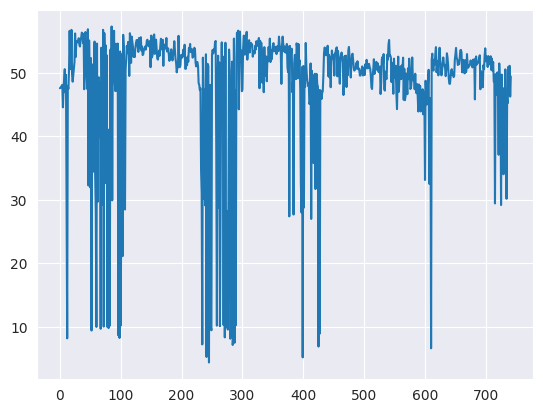

In [90]:
feat_a = dict(
    # mean=segment.audio_features.mean(dim=1),
    magnitude=segment.audio_features.norm(dim=1),
)

for k, v in feat_a.items():
    plt.plot(v, label=k)